**Duc Nguyen**

# Translocation Analysis

The goal of this assignment is to:
- examine where translocations occur genome-wide
- quantify the level of enrichment

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0. Preprocess

In [2]:
# load the tsv file
df = pd.read_csv("RF204_Alt055.tlx", delimiter="\t")
df

,Qname,Rname,Junction,Strand,Rstart,Rend,B_Rname,B_Rstart,B_Rend,B_Strand,B_Qstart,B_Qend,Qstart,Qend,Qlen,Seq,J_Seq
0,M01407:49:000000000-A7CDB:1:2109:6155:16526,chr1,10083,1,10083,10229,chr11,36594883,36595029,-1,3,149,163,311,335.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,taaccctaaccctaacccta
1,M01407:49:000000000-A7CDB:1:2108:13218:28605,chr1,10117,1,10117,10209,chr11,36594877,36595029,-1,3,155,158,251,NaN,TGGAGAGGGTTTCCCCTCAAAGGAATACTTCTTTTCCTTTTGAGCT...,ccaaccctaaccctaaccct
2,M01407:49:000000000-A7CDB:1:2103:6761:8534,chr1,10123,1,10123,10214,chr11,36594877,36595029,-1,3,155,158,245,NaN,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,ctaaccctaaccctaaccct
3,M01407:49:000000000-A7CDB:1:2111:23575:24144,chr1,10140,1,10140,10256,chr11,36594896,36595029,-1,3,136,137,251,NaN,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,cctaaccctaaccctaaccc
4,M01407:49:000000000-A7CDB:1:1104:9047:15418,chr1,10154,1,10154,10248,chr11,36594881,36595029,-1,3,151,149,240,337.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,taacccctaaccctaaccct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28547,M01407:49:000000000-A7CDB:1:2113:14748:17996,chrY,58991491,1,58991491,58991600,chr11,36594877,36595029,-1,3,155,189,298,323.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,ctgcctgcagtggcattgtg
28548,M01407:49:000000000-A7CDB:1:1114:20957:12350,chrY,58995345,-1,58995280,58995345,chr11,36594892,36595029,-1,3,140,140,205,223.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,gtatctctgcaatgatcaat
28549,M01407:49:000000000-A7CDB:1:1101:20541:23758,chrY,59028748,-1,59028699,59028748,chr11,36594893,36595029,-1,3,139,138,187,206.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,TATATCTGTGAACAGCAGTG
28550,M01407:49:000000000-A7CDB:1:2105:8746:18201,chrY,59363328,-1,59363218,59363328,chr11,36594889,36595029,-1,3,143,141,251,NaN,TGGAGAGGGGTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,ggttagggttagggttaggg


In [3]:
# check the integrity of Junction column
# if Strand = 1, Junction = Rstart; if Stran = -1, Junction = Rend
print(np.sum(df[df['Junction']==df['Rstart']]['Strand']==-1))
print(np.sum(df[df['Junction']==df['Rend']]['Strand']==1))

0
0


In [4]:
# check NA values
print(np.sum((df.isna())))
# All NA values are in the query length column

Qname         0
Rname         0
Junction      0
Strand        0
Rstart        0
Rend          0
B_Rname       0
B_Rstart      0
B_Rend        0
B_Strand      0
B_Qstart      0
B_Qend        0
Qstart        0
Qend          0
Qlen        720
Seq           0
J_Seq         0
dtype: int64


In [5]:
# load chromosome names and lengths
chromosomes = pd.read_csv('ChromInfo.txt', delimiter='\t', header=None)
chromosomes = chromosomes.set_index(0).T.to_dict('index')[1]
chromosomes

{'chr1': 249250621,
 'chr10': 135534747,
 'chr11': 135006516,
 'chr12': 133851895,
 'chr13': 115169878,
 'chr14': 107349540,
 'chr15': 102531392,
 'chr16': 90354753,
 'chr17': 81195210,
 'chr18': 78077248,
 'chr19': 59128983,
 'chr2': 243199373,
 'chr20': 63025520,
 'chr21': 48129895,
 'chr22': 51304566,
 'chr3': 198022430,
 'chr4': 191154276,
 'chr5': 180915260,
 'chr6': 171115067,
 'chr7': 159138663,
 'chr8': 146364022,
 'chr9': 141213431,
 'chrM': 16571,
 'chrX': 155270560,
 'chrY': 59373566}

### 1. Global view approach: Bin count

We divide each chromosomes into bins along its length, then count the number of translocations appearing in each bin. It is possible since the maximum length of translocation site ($Rend - Rstart$) is 1433, and the mean is 115 bases, which are very small compared to the chromosomes' lengths. Therefore, the possibility that a translocation stretches along two adjacent bins is extremely low.

#### 1a. Count

In [6]:
(df['Rend']-df['Rstart']).describe()

count    28552.000000
mean       140.422142
std        103.039651
min         24.000000
25%         66.000000
50%        115.000000
75%        189.000000
max       1433.000000
dtype: float64

Below, we choose a bin size of 1 Mb, and do not record zero bin counts (no translocations). Finally, export the Chromosome, Start, End, and Count into a bedGraph file.

In [7]:
def count_by_bin(file, bin_size = 1000000, to_file=False):
    
    df = pd.read_csv(file, delimiter="\t")
    df['bin'] = df['Junction'] // bin_size
    bin_counts = pd.DataFrame(columns = ['Chrom', 'Bin', 'Count', 'Start', 'End'])

    for chrom_name, chrom_length in chromosomes.items():
        chrom_df = df[df['Rname'] == chrom_name]
        bins = chrom_df.groupby('bin').groups.keys()
        counts = chrom_df.groupby('bin')['Qname'].count()

        chrom_count_df = pd.DataFrame({'Chrom': chrom_name, 'Bin': bins, 'Count': counts})
        chrom_count_df['Start'] = chrom_count_df['Bin']*bin_size
        chrom_count_df['End'] = np.where((chrom_count_df['Bin']+1)*bin_size <= chrom_length,
                                        (chrom_count_df['Bin']+1)*bin_size, chrom_length)
        bin_counts = pd.concat([bin_counts, chrom_count_df])
    
    if to_file:
        if not os.path.exists('bin_count'):
            os.mkdir('bin_count')
        bin_counts[['Chrom', 'Start', 'End', 'Count']].to_csv(f'bin_count/bin_count_{bin_size//1000000}Mb.bg', sep="\t", index=False, header=False)
    
    return bin_counts

In [8]:
bin_size = 1000000
bin_counts = count_by_bin("RF204_Alt055.tlx", bin_size, to_file=True)
bin_counts

,Chrom,Bin,Count,Start,End
0,chr1,0,8,0,1000000
1,chr1,1,19,1000000,2000000
2,chr1,2,8,2000000,3000000
3,chr1,3,7,3000000,4000000
4,chr1,4,9,4000000,5000000
...,...,...,...,...,...
13,chrY,13,9,13000000,14000000
17,chrY,17,1,17000000,18000000
28,chrY,28,1,28000000,29000000
58,chrY,58,3,58000000,59000000


#### 1b. Evaluation

We would like to do some downstream analysis to see whether the bin counts are helpful, or a more rigorous approach is required.

In [9]:
# summary statistics
max_depth = bin_counts['Count'].max()
min_depth = bin_counts['Count'].min()
print(f'Total genome length: {sum(list(chromosomes.values()))}')
print('Total bins:', bin_counts['Bin'].count())
print('Total translocations:', bin_counts['Count'].sum())
print('Maximal count: ', max_depth, '(', ",".join(bin_counts[bin_counts['Count'] == max_depth]['Chrom'].unique()), ')')
print('Minimal count: ', min_depth, '(', ",".join(bin_counts[bin_counts['Count'] == min_depth]['Chrom'].unique()), ')')
print('Average count per bin: ', round(bin_counts['Count'].mean(), 2))

Total genome length: 3095693983
Total bins: 2853
Total translocations: 28552
Maximal count:  5403 ( chr11 )
Minimal count:  1 ( chr1,chr10,chr12,chr13,chr14,chr15,chr16,chr18,chr19,chr2,chr20,chr22,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chrX,chrY )
Average count per bin:  10.01


In [10]:
# statistics per chromosome
for chrom_name, chrom_length in chromosomes.items():
    chrom_df = bin_counts[bin_counts['Chrom'] == chrom_name]
    print(f'{chrom_name}')
    print(f'\tLength: {chrom_length}')
    print('\tBin: ', chrom_df['Chrom'].count())
    print('\tTranslocation: ', chrom_df['Count'].sum())
    print('\tMaximal count: ', chrom_df['Count'].max())
    print('\tMinimal count: ', chrom_df['Count'].min())
    print('\tAverage bin count: ', round(chrom_df['Count'].mean(), 2))
    

chr1
	Length: 249250621
	Bin:  228
	Translocation:  2150
	Maximal count:  50
	Minimal count:  1
	Average bin count:  9.43
chr10
	Length: 135534747
	Bin:  134
	Translocation:  977
	Maximal count:  22
	Minimal count:  1
	Average bin count:  7.29
chr11
	Length: 135006516
	Bin:  133
	Translocation:  7919
	Maximal count:  5403
	Minimal count:  3
	Average bin count:  59.54
chr12
	Length: 133851895
	Bin:  132
	Translocation:  1062
	Maximal count:  177
	Minimal count:  1
	Average bin count:  8.05
chr13
	Length: 115169878
	Bin:  96
	Translocation:  869
	Maximal count:  32
	Minimal count:  1
	Average bin count:  9.05
chr14
	Length: 107349540
	Bin:  89
	Translocation:  635
	Maximal count:  75
	Minimal count:  1
	Average bin count:  7.13
chr15
	Length: 102531392
	Bin:  79
	Translocation:  841
	Maximal count:  255
	Minimal count:  1
	Average bin count:  10.65
chr16
	Length: 90354753
	Bin:  81
	Translocation:  617
	Maximal count:  28
	Minimal count:  1
	Average bin count:  7.62
chr17
	Length: 811952

Next, we visualize the frequency of genome-wide translocations using Matplotlib, and export into a PDF file to preserve resolution.

In [11]:
color_map = {
        2000: 'purple',
        500: 'blue',
        100:'green',
        20:'orange',
        5: 'red',
        1: 'black'
    }

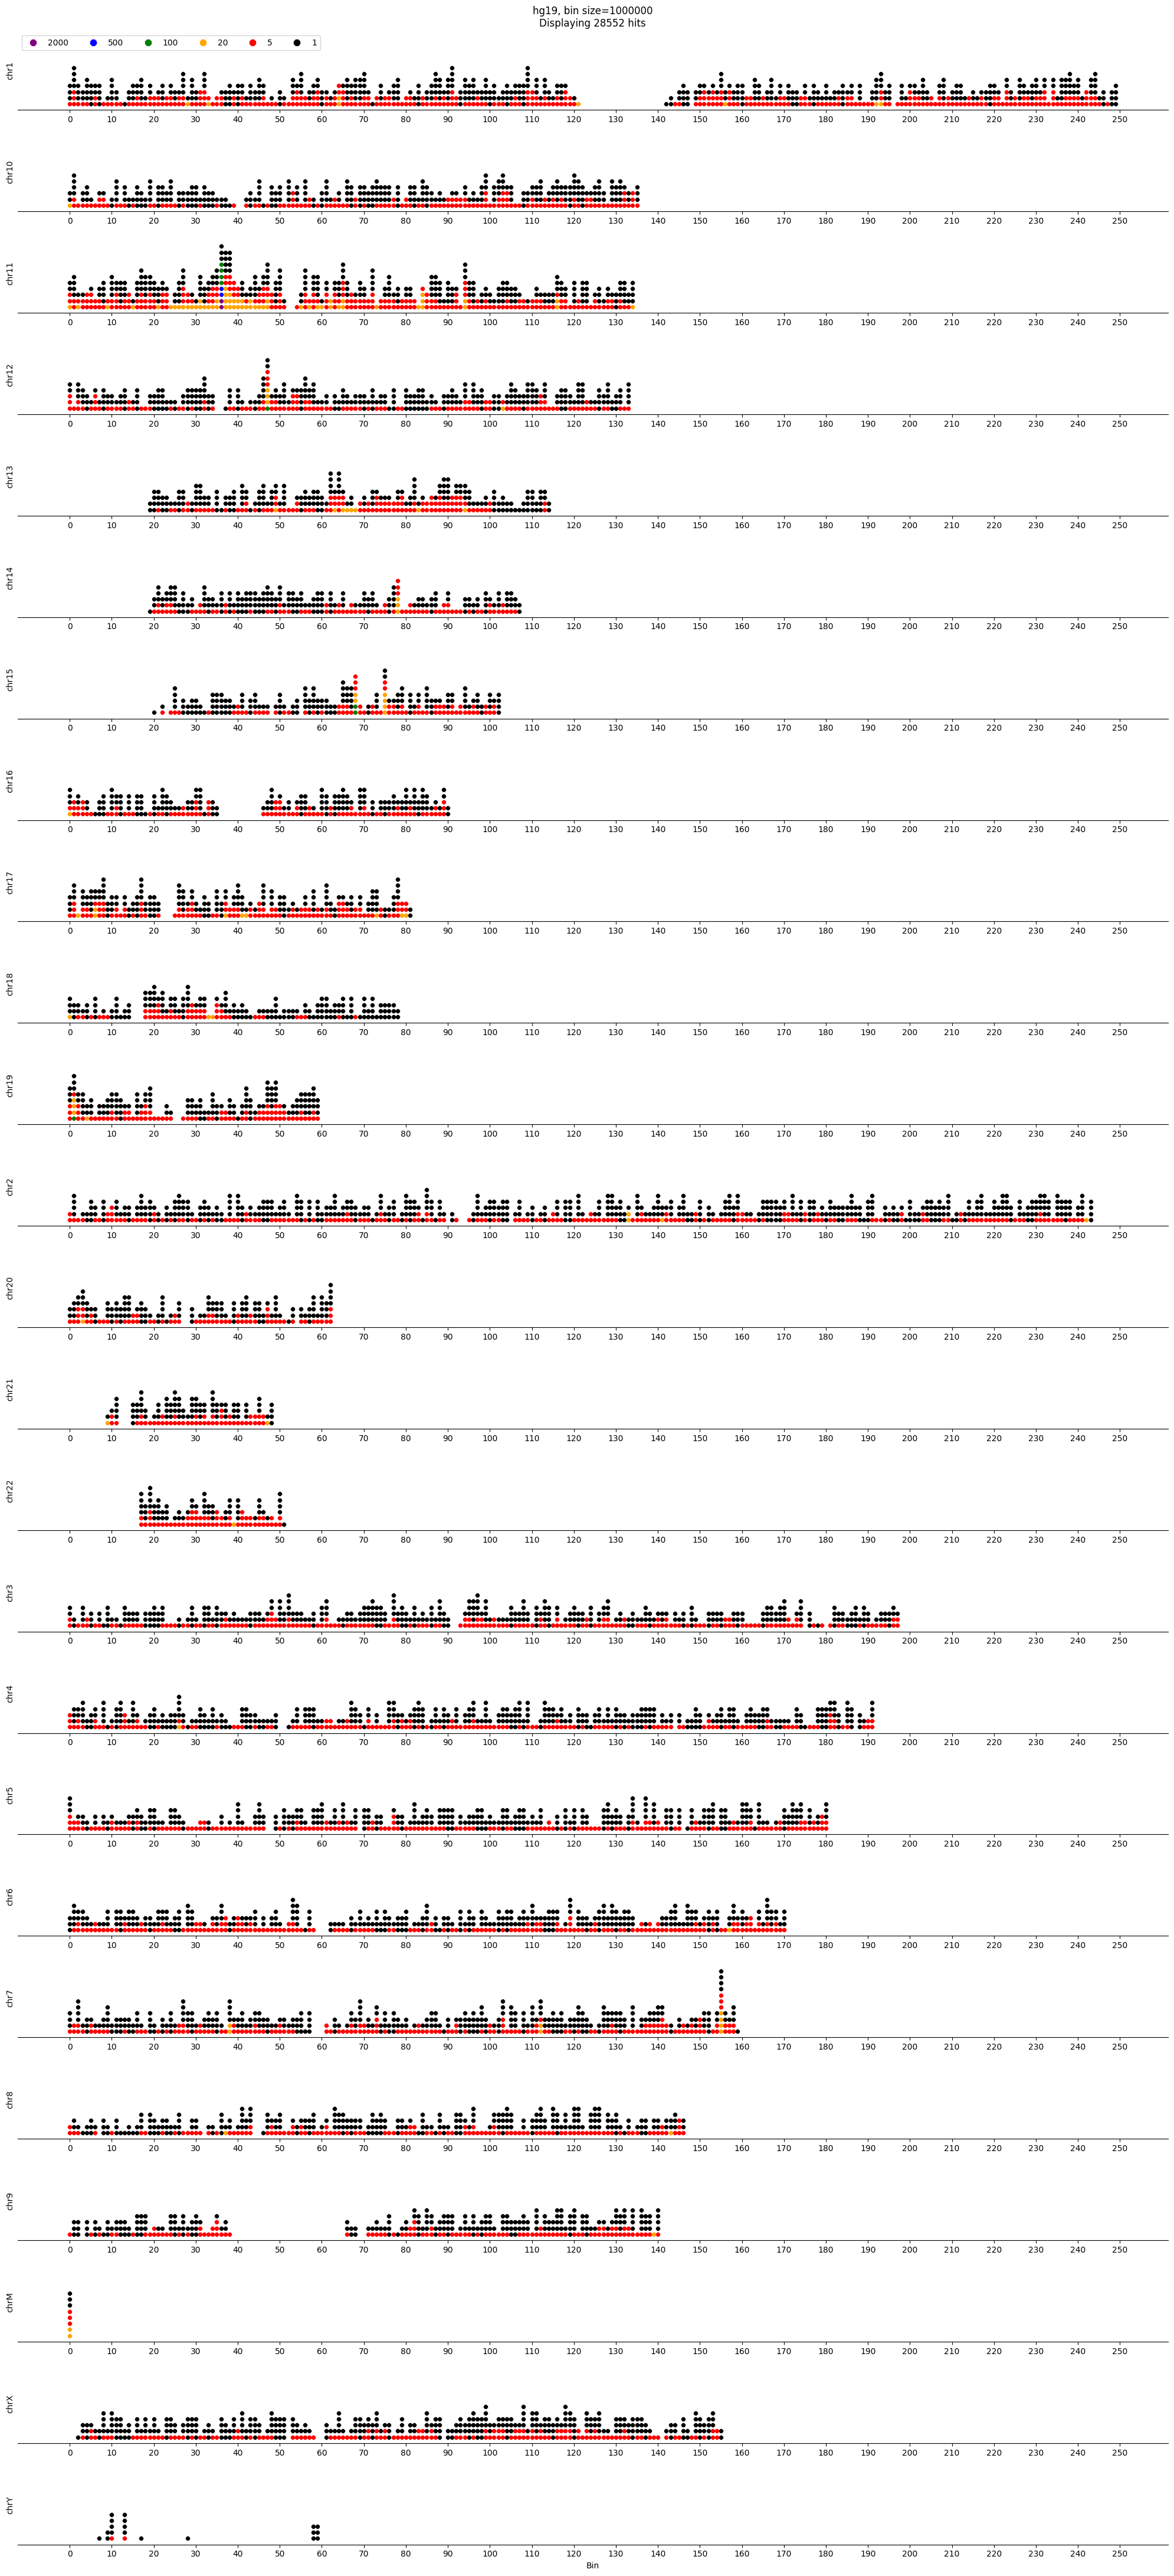

In [12]:
import matplotlib.lines as lines

def dot_plot(data, color_map, chromosomes, title="Hit map", bin_size=1000000):
    
    # divide the raw count into small chunks
    def display_count(frequency, max_values):
        display_count=[]
        for max_val in max_values:
            display_count.append(frequency//max_val)
            frequency = frequency%max_val
        return display_count

    # dotplot
    fig, axes = plt.subplots(len(chromosomes), 1, sharex=True, figsize=(20, 1.75*len(chromosomes)))
    for index, (chrom_name, chrom_length) in enumerate(chromosomes.items()):
        
        sub_data = data[data['Chrom'] == chrom_name][['Bin', 'Count']]
        sub_data = np.array(sub_data)
        for value, freq in zip(sub_data[:,0], sub_data[:,1]):    
            display_counts = display_count(freq, color_map)
            for i, count in enumerate(display_counts):
                axes[index].plot([value]*count, list(range(sum(display_counts[:i]), sum(display_counts[:(i+1)]))), 
                        '8', ms=4.5, linestyle='', c=list(color_map.values())[i])
        
        # show y-axis labels and ticks
        for spine in ['top', 'left', 'right']:
            axes[index].spines[spine].set_visible(False)
        axes[index].set_ylim(-1, 12)
        axes[index].set_yticks([])
        axes[index].set_ylabel(chrom_name)
        axes[index].xaxis.set_tick_params(which='both', labelbottom=True)
    
    # # show x-axis and title
    axes[0].set_title(title)
    axes[-1].set_xticks(np.arange(0, math.ceil(max(chromosomes.values())//bin_size)+2, 10))
    axes[-1].set_xlabel('Bin')
    
    # legend
    symbols = []
    for max_val, color in color_map.items():
        symbols.append(lines.Line2D([], [], color=color, marker='8', linestyle='None',
                        ms=8, label=max_val))
    axes[0].legend(handles=symbols, loc='upper left', ncol = 6)
    
    plt.tight_layout()
    plt.savefig(f'bin_count/bin_count_{bin_size//1000000}Mb_plot.pdf')

input_data = bin_counts[['Chrom', 'Bin', 'Count']]
display_hit_count = bin_counts['Count'].sum()

dot_plot(input_data, color_map, chromosomes, f'hg19, bin size={bin_size}\nDisplaying {display_hit_count} hits', bin_size)

The highest concentration of translocations (count = 5403) occurs at the 36th bin (36,000,000-37,000,000) on chromosome 11.
Less significant hotspots (count > 100) are also observed at 68th bin on chromosome 15, 47th bin on chromosome 12, and 1st bin on chromosome 19.

We continue examining the hotspot on chromosome 11.

In [13]:
df['Bin'] = df['Junction'] // bin_size
hotspots = df[(df['Rname']  == 'chr11') & (df['Bin'] == 36)]
hotspots['Junction'].describe()

count    5.403000e+03
mean     3.659547e+07
std      4.330433e+04
min      3.601839e+07
25%      3.659380e+07
50%      3.659484e+07
75%      3.659662e+07
max      3.699800e+07
Name: Junction, dtype: float64

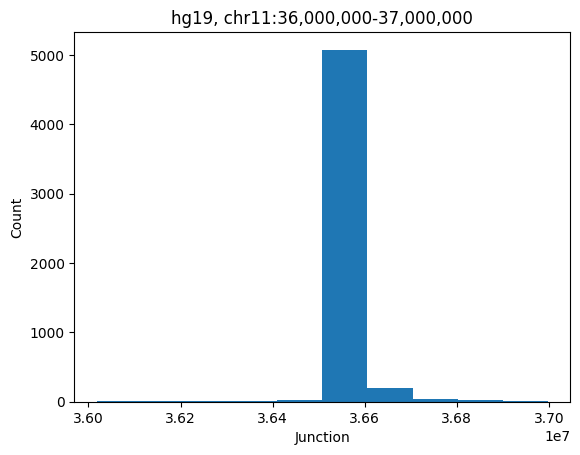

In [14]:
plt.hist(hotspots['Junction'], bins=10)
plt.xlabel('Junction')
plt.ylabel('Count')
plt.title('hg19, chr11:36,000,000-37,000,000')
plt.show()

More than half of translocations in this 1Mb bin concentrates within 2000 bases around chr11:36,594,840. 

The histogram also shows a strong convergence of junctions.

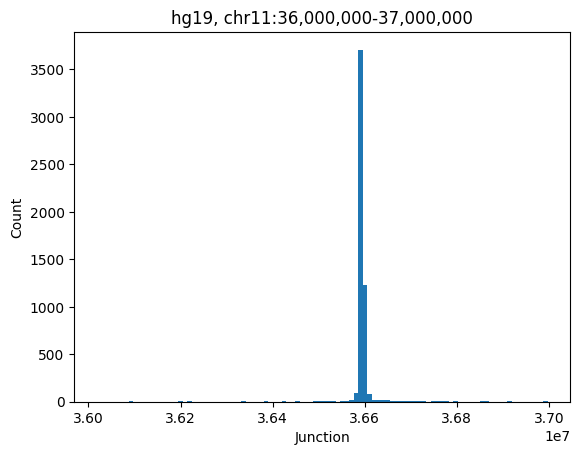

In [15]:
plt.hist(hotspots['Junction'], bins=100)
plt.xlabel('Junction')
plt.ylabel('Count')
plt.title('hg19, chr11:36,000,000-37,000,000')
plt.show()

When we increase the bin size to 100, a quarter of translocation deviate from the original bin, meaning that the translocations in this specific region do not distribute uniformly as we thought.

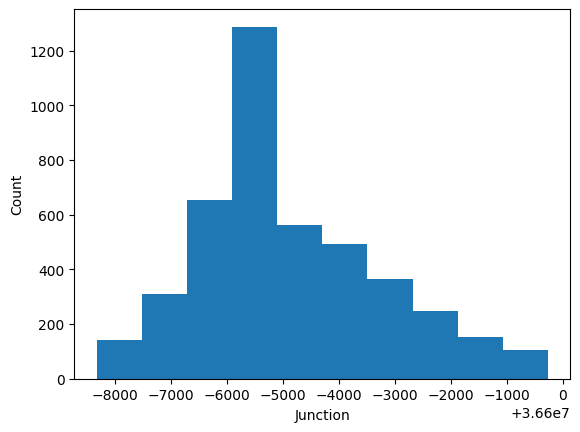

In [16]:
quantile10 = hotspots['Junction'].quantile(0.10)
quantile90 = hotspots['Junction'].quantile(0.90)
plt.hist(hotspots[(hotspots['Junction'] >= quantile10) & (hotspots['Junction'] <= quantile90)]['Junction'])
plt.xlabel('Junction')
plt.ylabel('Count')
plt.show()

A histogram between 10th percentile and 90th percentile shows clearer deviation of junction sites, i.e. translocation do not occur at a single position on the chromosome, but rather in a window.

#### 2c. Identification of significant hotspots

In the example above, we identified hotspots of enrichment via a specific threshold (count > 100). However, we would like to detect these hotspots via statistical tests, since graphical representation can be misleading.

We expect that the frequencies of bin counts follow a Poisson distribution.

In [17]:
counts = bin_counts.groupby('Count')['Chrom'].count()
count_df = pd.DataFrame({'Value': counts.index.to_list(), 'Count': counts.to_list()})

# add values with zero counts
zero_count_values = [x for x in np.arange(count_df['Value'].min(), count_df['Value'].max()+1) if x not in set(count_df['Value'])]
temp = pd.DataFrame({'Value': zero_count_values, 'Count': 0})
count_df = pd.concat([count_df, temp], ignore_index=True).sort_values(by='Value')

# compute frequencies of values
count_df['Freq'] = count_df['Count']/count_df['Count'].sum()
count_df

,Value,Count,Freq
0,1,65,0.022783
1,2,129,0.045216
2,3,218,0.076411
3,4,267,0.093586
4,5,317,0.111111
...,...,...,...
5399,5399,0,0.000000
5400,5400,0,0.000000
5401,5401,0,0.000000
5402,5402,0,0.000000


Critical point: 3.0


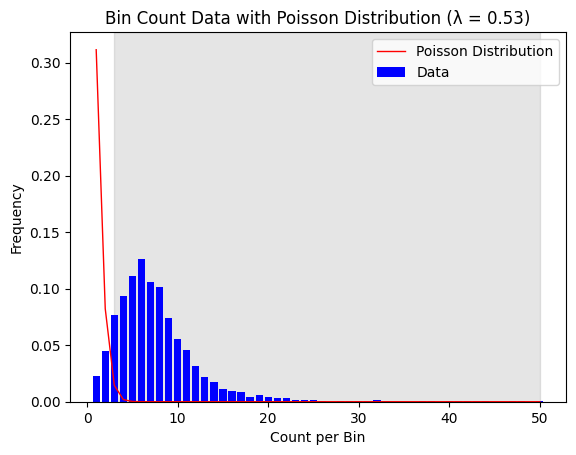

In [18]:
x = count_df['Value']
y = count_df['Freq']

# estimate lambda using the mean of the data
lambda_est = count_df['Count'].mean()

p_val = 0.05

from scipy.stats import poisson
min_sig_count = poisson.ppf(1-p_val, mu=lambda_est) + 1
print(f'Critical point: {min_sig_count}')

# calculate the Poisson probability mass function
poisson_pmf = poisson.pmf(x, mu=lambda_est)

# plot data as a bar graph
plt.bar(x[:50], y[:50], color='blue', label='Data')

# plot the Poisson distribution as a line plot
plt.plot(x[:50], poisson_pmf[:50], color='red', label='Poisson Distribution', linewidth=1)

# shade significant portion
plt.axvspan(min_sig_count, max(x[:50]), color='gray', alpha=0.2, zorder=0)

# set labels and title
plt.xlabel('Count per Bin')
plt.ylabel('Frequency')
plt.title(f'Bin Count Data with Poisson Distribution (λ = {lambda_est:.2f})')
plt.legend(loc='upper right')
plt.show()

The data looks like a Poisson distribution, but our estimated mean, $\lambda$, seems off. The reason may be because our highest count is too far away from other values. We try to estimate the mean again, this time without the highest value.

In [19]:
counts = bin_counts.groupby('Count')['Chrom'].count()[:-1]
count_df = pd.DataFrame({'Value': counts.index.to_list(), 'Count': counts.to_list()})

# add values with zero counts
zero_count_values = [x for x in np.arange(count_df['Value'].min(), count_df['Value'].max()+1) if x not in set(count_df['Value'])]
temp = pd.DataFrame({'Value': zero_count_values, 'Count': 0})
count_df = pd.concat([count_df, temp], ignore_index=True).sort_values(by='Value')

# compute frequencies of values
count_df['Freq'] = count_df['Count']/count_df['Count'].sum()
count_df

,Value,Count,Freq
0,1,65,0.022791
1,2,129,0.045231
2,3,218,0.076438
3,4,267,0.093619
4,5,317,0.111150
...,...,...,...
251,251,0,0.000000
252,252,0,0.000000
253,253,0,0.000000
254,254,0,0.000000


Critical point: 18.0


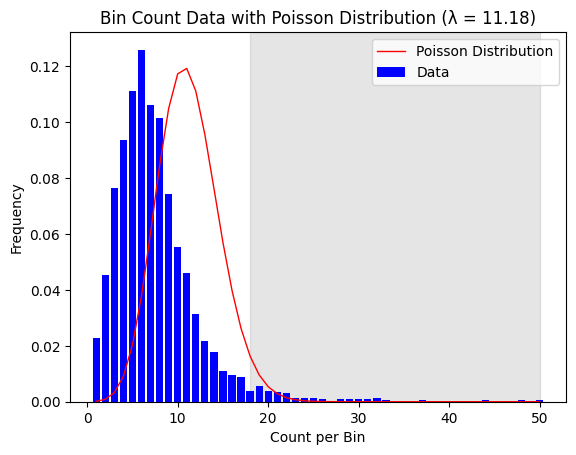

In [20]:
x = count_df['Value']
y = count_df['Freq']

# estimate lambda using the mean of the data
lambda_est = count_df['Count'].mean()

p_val = 0.05

from scipy.stats import poisson
min_sig_count = poisson.ppf(1-p_val, mu=lambda_est) + 1
print(f'Critical point: {min_sig_count}')

# calculate the Poisson probability mass function
poisson_pmf = poisson.pmf(x, mu=lambda_est)

# plot data as a bar graph
plt.bar(x[:50], y[:50], color='blue', label='Data')

# plot the Poisson distribution as a line plot
plt.plot(x[:50], poisson_pmf[:50], color='red', label='Poisson Distribution', linewidth=1)

# shade significant portion
plt.axvspan(min_sig_count, max(x[:50]), color='gray', alpha=0.2, zorder=0)

# set labels and title
plt.xlabel('Count per Bin')
plt.ylabel('Frequency')
plt.title(f'Bin Count Data with Poisson Distribution (λ = {lambda_est:.2f})')
plt.legend(loc='upper right')
plt.show()

The two curves fit together much better, although still slightly off. We could have perform Chi-square Goodness-of-Fit test in R to determine whether they are significantly similar. Somehow the `scipy.stats.chisquare` function in Python did not work for me.

Using a threshold of 0.05, we compute the p-value for each bin, and export the results to a new bedGraph file.

In [21]:
bin_counts['p_value'] = 1-poisson.cdf(list(bin_counts['Count']), mu=lambda_est)
bin_counts['Hotspot'] = bin_counts['p_value'] < p_val
bin_counts

,Chrom,Bin,Count,Start,End,p_value,Hotspot
0,chr1,0,8,0,1000000,0.783970,False
1,chr1,1,19,1000000,2000000,0.010944,True
2,chr1,2,8,2000000,3000000,0.783970,False
3,chr1,3,7,3000000,4000000,0.868317,False
4,chr1,4,9,4000000,5000000,0.679153,False
...,...,...,...,...,...,...,...
13,chrY,13,9,13000000,14000000,0.679153,False
17,chrY,17,1,17000000,18000000,0.999831,False
28,chrY,28,1,28000000,29000000,0.999831,False
58,chrY,58,3,58000000,59000000,0.995723,False


In [22]:
bin_counts[['Chrom', 'Start', 'End', 'Count', 'p_value']].to_csv(f'bin_count/bin_count_{bin_size//1000000}Mb_sig.bg', sep="\t", index=False, header=False)

In [23]:
print('Significant hotspot count: ', bin_counts[bin_counts['Hotspot']]['Count'].count())
print('Chromosome with hotspots: ', ', '.join(bin_counts[bin_counts['Hotspot']]['Chrom'].unique()))

Significant hotspot count:  145
Chromosome with hotspots:  chr1, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr2, chr20, chr21, chr22, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chrM


We visualize the bin count again, this time with asterisks representing significant hotspots.

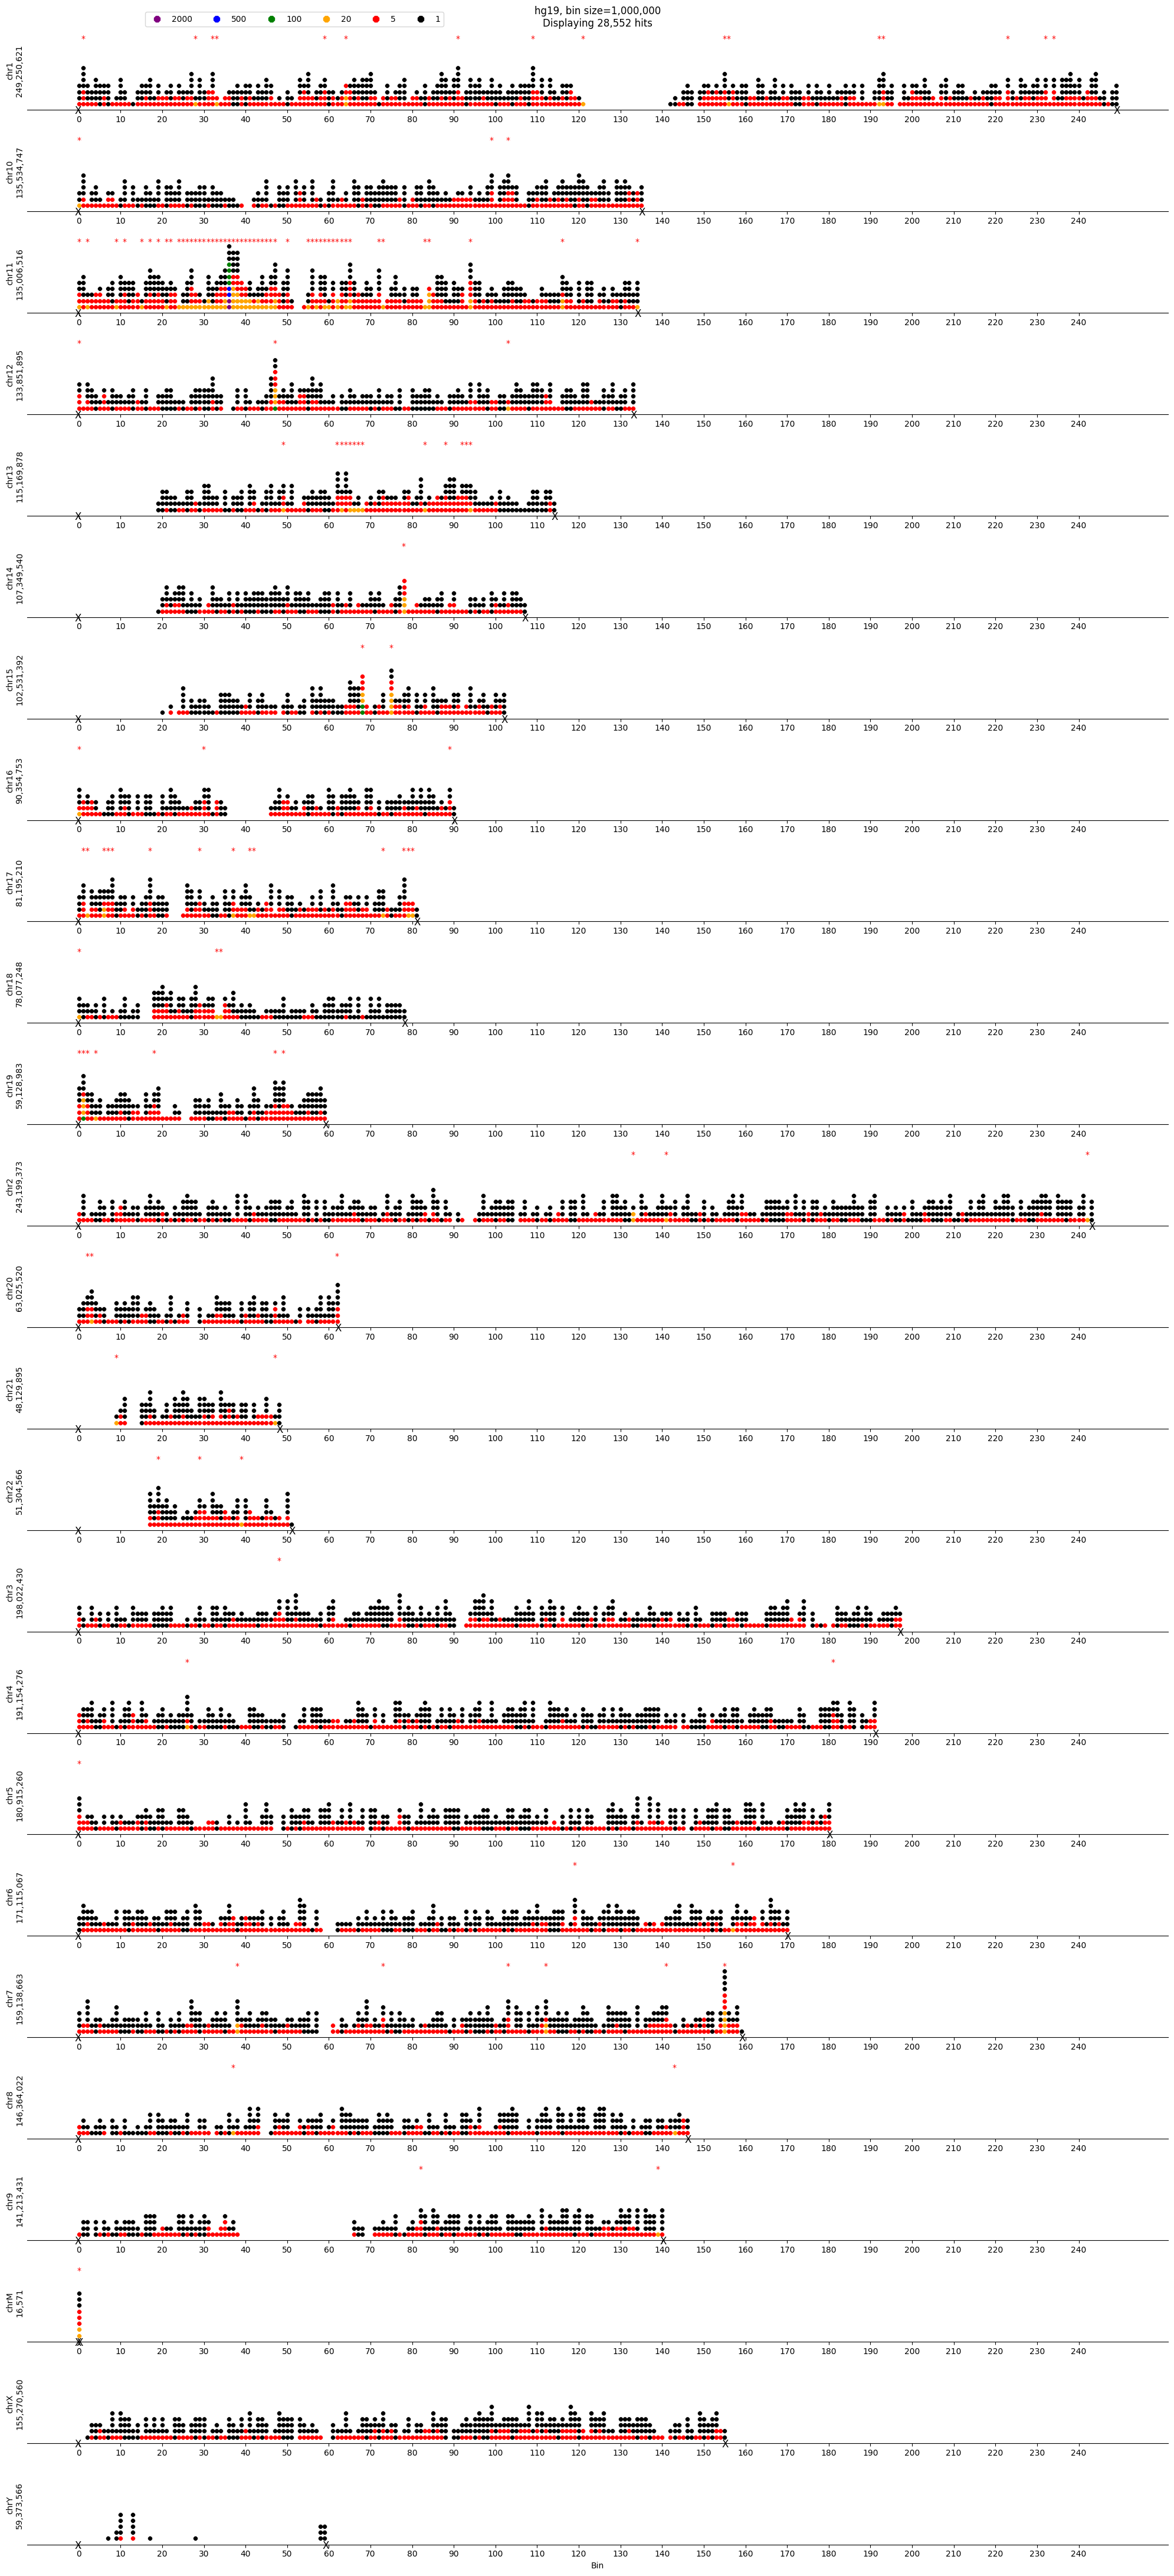

In [24]:
import matplotlib.lines as lines

def dot_plot_v2(data, color_map, chromosomes, title="Hit map", bin_size=1000000):
    
    # divide the raw count into small chunks
    def display_count(frequency, max_values):
        display_count=[]
        for max_val in max_values:
            display_count.append(frequency//max_val)
            frequency = frequency%max_val
        return display_count

    fig, axes = plt.subplots(len(chromosomes), 1, sharex=True, figsize=(20, 1.75*len(chromosomes)))
    for index, (chrom_name, chrom_length) in enumerate(chromosomes.items()):
        
        sub_data = data[data['Chrom'] == chrom_name][['Bin', 'Count', 'Hotspot']]
        sub_data = np.array(sub_data)
        for value, freq, hotspot in zip(sub_data[:,0], sub_data[:,1], sub_data[:,2]):    
            
            # dotplot
            display_counts = display_count(freq, color_map)
            for i, count in enumerate(display_counts):
                axes[index].plot([value]*count, list(range(sum(display_counts[:i]), sum(display_counts[:(i+1)]))), 
                        '8', ms=4.5, linestyle='', c=list(color_map.values())[i])
            
            # mark hotspot of enrichment
            if hotspot:
                axes[index].text(value, 0.9, '*', fontsize=10, color='red', 
                                 horizontalalignment='center', verticalalignment='center',
                                 transform=axes[index].get_xaxis_transform())

        # mark chromosome ends
        axes[index].text(-1, 0, 'X', fontsize=12, color='black',
                         horizontalalignment='left', verticalalignment='center_baseline',
                         transform=axes[index].get_xaxis_transform())
        axes[index].text(sub_data[-1][0] + 1, 0, 'X', fontsize=12, color='black',
                         horizontalalignment='right', verticalalignment='center_baseline',
                         transform=axes[index].get_xaxis_transform())
            
        # show y-axis labels and ticks
        for spine in ['top', 'left', 'right']:
            axes[index].spines[spine].set_visible(False)
        axes[index].set_ylim(-1, 12)
        axes[index].set_yticks([])
        axes[index].set_ylabel(f'{chrom_name}\n{chrom_length:,}')
        axes[index].xaxis.set_tick_params(which='both', labelbottom=True)
    
    # # show x-axis and title
    axes[0].set_title(title)
    axes[-1].set_xticks(np.arange(0, math.ceil(max(chromosomes.values())//bin_size)+1, 10))
    axes[-1].set_xlabel('Bin')
    
    # legend
    symbols = []
    for max_val, color in color_map.items():
        symbols.append(lines.Line2D([], [], color=color, marker='8', linestyle='None',
                        ms=8, label=max_val))
    axes[0].legend(handles=symbols, loc='upper left', ncol = len(color_map), bbox_to_anchor=(0.1, 1.3))
    
    plt.tight_layout()
    plt.savefig(f'bin_count/bin_count_{bin_size//1000000}Mb_plot_v2.pdf')

input_data = bin_counts[['Chrom', 'Bin', 'Count', 'Hotspot']]
display_hit_count = bin_counts['Count'].sum()
dot_plot_v2(input_data, color_map, chromosomes, f'hg19, bin size={bin_size:,}\nDisplaying {display_hit_count:,} hits', bin_size)

The statistical test helps us further estimate the width and depth of enrichment. The hotspots in the head of chromosome 19 has high depth, so can be easily detected. Otherwise, the hotspots in the middle of chromosome 13 have lower depth but higher width, and can be overlooked if we did not perform the statistical test.

### 2. Local view approach: Genome coverage with `BEDTools`

Although binning gives us a good overview of where the translocations occur, the loss of information is foreseeable. Since the binning range is 1 Mb, it is difficult to infer the spatial distribution of translocations in one bin without additional work, as shown above. We know that translocations do not appear uniformly on the chromosome. Also, since the lengths of chromosomes are diverse, a universal bin size might not work well on very long/very short one, e.g. mitochondrial DNA.

`BEDTools` may solve these problems, as the program allows us to measure the genome-wide coverage on each bases.
We need both `Rstart` and `Rend` of translocations, instead of dealing with a single junction point. The coverage of a base is the number of translocations overlapping at the base's position. For example:
<pre>
Translocation #1:       * * * * *
Translocation #2:           * * * * * *
Coverage per base:      1 1 2 2 2 1 1 1
</pre>
A base is *covered* if its coverage is larger than 0.

This approach should provide us spatial distribution of translocations with base-wise resolution.

In [25]:
# check if any error in coordinates, like Rstart >= Rend
df[(df['Rstart'] >= df['Rend'])]['Qname'].count()

0

#### 2a. Count

First, we export *Rname*, *Rstart*, *Rend* columns to a BED file.

In [26]:
# export to BED file
if not os.path.exists('bed_count'):
    os.mkdir('bed_count')
df[['Rname', 'Rstart', 'Rend']].to_csv('bed_count/translocation.bed', sep="\t", index=False, header=False)

Next, sort the chromosome by names and coordinates. The purpose is to group records of the same chromosome together.

In [27]:
!sort -k1,1 -k2,2n bed_count/translocation.bed > bed_count/translocation.sorted.bed

Then we compute the coverage per base with *bedtools*. The `-bg` flag groups bases with the same coverage together to reduce the file size.

In [28]:
!bedtools genomecov -i bed_count/translocation.sorted.bed -g ChromInfo.txt -bg > bed_count/transloc_bed_count.bg

#### 2b. Evaluation

We compute summary statistics of coverages from the bedGraph file.

In [29]:
bed_covs = pd.read_csv("bed_count/transloc_bed_count.bg", delimiter="\t", header=None) # load file
bed_covs.columns = ['Chrom', 'Start', 'End', 'Coverage']

In [30]:
bed_covs['Length'] = bed_covs['End'] - bed_covs['Start']
covered_base_count = bed_covs['Length'].sum() #sum

In [31]:
bed_covs['Sum_coverage'] = bed_covs['Coverage'] * bed_covs['Length']
mean_cov = bed_covs['Sum_coverage'].sum() / bed_covs['Length'].sum() # average

In [32]:
max_cov = bed_covs['Coverage'].max()
max_coords = bed_covs[bed_covs['Coverage'] == max_cov][['Start', 'End']].to_numpy() # max

In [33]:
# summary statistics
print(f'Total bases covered: {covered_base_count} ({round(covered_base_count/sum(list(chromosomes.values()))*100, 4)}% of the genome)')
print(f'Mean coverage: {round(mean_cov, 4)} (on covered bases)')
print('Max coverage: ',max_cov, '(',','.join(bed_covs[bed_covs['Coverage'] == max_cov]['Chrom'].unique()),
      ':', ', '.join([f"{row[0]}-{row[1]}" for row in max_coords]), ')')

Total bases covered: 3031246 (0.0979% of the genome)
Mean coverage: 1.3227 (on covered bases)
Max coverage:  239 ( chr11 : 36594358-36594359 )


The mean coverage is slightly larger than 1, indicating that a majority of translocations are not overlapped.
The highest base coverage is on chromosome 11 at base 36594358, which agrees with our bin count results.

We implemented a simple command line tool in R using *karyoploteR* library to visualize the genome-wide coverage.  This script also allows us to zoom into regions of interests.

##### Whole-genome

In [34]:
!Rscript plot_karyotype.R -i bed_count/transloc_bed_count.bg -o bed_count/bed_cov_plot.pdf

null device 
          1 


<img src="bed_count/bed_cov_plot.png" width="800" height="800">

The real genome-wide distribution of translocations is much more discrete than the distribution from bin counts.

##### Best hotspot on chromosome 11

In [35]:
!Rscript plot_karyotype.R -i bed_count/transloc_bed_count.bg -o bed_count/bed_cov_plot_zoom_chr11.pdf -c chr11 -s 360e5 -e 370e5

null device 
          1 


<img src="bed_count/bed_cov_plot_zoom_chr11.png" width="800" height="800">

##### Second-best hotspots on chromosome 15

In [36]:
!Rscript plot_karyotype.R -i bed_count/transloc_bed_count.bg -o bed_count/bed_cov_plot_zoom_chr15.pdf -c chr15 -s 60e6 -e 80e6

null device 
          1 


<img src="bed_count/bed_cov_plot_zoom_chr15.png" width="800" height="800">

Clearly, this approach provides us with more detailed information than the bin count approach. It is possible to examine every single hotspots of enrichment, and assess whether the translocations are grouped together, or on a specific cytogenetic location/exon/intron/gene of interest.

### Reference

Aaron R. Quinlan, Ira M. Hall, *BEDTools: a flexible suite of utilities for comparing genomic features*, Bioinformatics, Volume 26, Issue 6, March 2010, Pages 841–842, https://doi.org/10.1093/bioinformatics/btq033

Bernat Gel & Eduard Serra. (2017). *karyoploteR: an R/Bioconductor package to plot customizable genomes displaying arbitrary data*. Bioinformatics, 31–33. https://doi.org/10.1093/bioinformatics/btx346
